# Customer Turnover Classification (Binary Classification) with Ensemble Methods, January 2018
# Introduction
* In this project, we'll build a classifier model to look at customer behavioral data, with customer turnover as our binary target variable.
* While my regression project was my very first dive into applied analytics outside the classroom, it was also my first time working with pandas, Jupyter notebooks, scikit-learn, numpy, and visualizations in Python. With those skills more developed, this project represents a greater opportunity to work on more in-depth concepts. 
* Real customer data is hard to come by; this is an artificial dataset that can be found here: https://www.iainpardoe.com/teaching/dsc433/data/Churn.xls 

# First Impressions

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.feature_selection import chi2, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from mlxtend.feature_selection import ColumnSelector
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

% matplotlib inline

In [2]:
df = pd.read_csv('/Users/jordanbauer/Data Mining Learning/Personal Projects/Classification/Churn_data.csv')
df_original = df
df.head()

Account Length  VMail Message  Day Mins  Eve Mins  Night Mins  Intl Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ Calls  Churn  Int'l Plan  VMail Plan  Day Calls  Day Charge  \
0               1      0           0           1        110       45.07   
1               1      0           0           1        123       27.47   
2               0      0           0           0        114       41.38   
3               2      0           1           0         71       50.90   
4               3      0           1           0        113       28.34   

   Eve Calls  Eve Charge  Night Calls  Night Charge  Intl Calls  Intl Charge  \
0         99       16.78           91         11.01           3         2.70   
1        103       16.62          103         11.45           3         3.70   
2        110       10.30          104          7.32           5         3.29   
3         88        5.26           89          8.86           7         1.78   
4        122       12.61          121          8.41           3         2.73   

  State  Area Code  
0    KS        415  
1    OH        415  
2    NJ        415  
3    OH        408  
4    OK        415

In [3]:
df.shape

(3333, 20)

In [4]:
df.describe()

Account Length  VMail Message     Day Mins     Eve Mins   Night Mins  \
count     3333.000000    3333.000000  3333.000000  3333.000000  3333.000000   
mean       101.064806       8.099010   179.775098   200.980348   200.872037   
std         39.822106      13.688365    54.467389    50.713844    50.573847   
min          1.000000       0.000000     0.000000     0.000000    23.200000   
25%         74.000000       0.000000   143.700000   166.600000   167.000000   
50%        101.000000       0.000000   179.400000   201.400000   201.200000   
75%        127.000000      20.000000   216.400000   235.300000   235.300000   
max        243.000000      51.000000   350.800000   363.700000   395.000000   

         Intl Mins  CustServ Calls        Churn   Int'l Plan   VMail Plan  \
count  3333.000000     3333.000000  3333.000000  3333.000000  3333.000000   
mean     10.237294        1.562856     0.144914     0.096910     0.276628   
std       2.791840        1.315491     0.352067     0.295879     0.447398   
min       0.000000        0.000000     0.000000     0.000000     0.000000   
25%       8.500000        1.000000     0.000000     0.000000     0.000000   
50%      10.300000        1.000000     0.000000     0.000000     0.000000   
75%      12.100000        2.000000     0.000000     0.000000     1.000000   
max      20.000000        9.000000     1.000000     1.000000     1.000000   

         Day Calls   Day Charge    Eve Calls   Eve Charge  Night Calls  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.435644    30.562307   100.114311    17.083540   100.107711   
std      20.069084     9.259435    19.922625     4.310668    19.568609   
min       0.000000     0.000000     0.000000     0.000000    33.000000   
25%      87.000000    24.430000    87.000000    14.160000    87.000000   
50%     101.000000    30.500000   100.000000    17.120000   100.000000   
75%     114.000000    36.790000   114.000000    20.000000   113.000000   
max     165.000000    59.640000   170.000000    30.910000   175.000000   

       Night Charge   Intl Calls  Intl Charge    Area Code  
count   3333.000000  3333.000000  3333.000000  3333.000000  
mean       9.039325     4.479448     2.764581   437.182418  
std        2.275873     2.461214     0.753773    42.371290  
min        1.040000     0.000000     0.000000   408.000000  
25%        7.520000     3.000000     2.300000   408.000000  
50%        9.050000     4.000000     2.780000   415.000000  
75%       10.590000     6.000000     3.270000   510.000000  
max       17.770000    20.000000     5.400000   510.000000

In [5]:
df = df.rename(index=str, columns={'Int\'l Plan': 'Intl Plan'})

We can see that about 14.5% of our observations are positive, so our two classes are fairly imbalanced. Tree-based algorithms are fairly robust to imbalance and others, like support vector machine and logistic regression, have weighting so we can balance our classes. We could manufacture some synthetic minority class observations and/or undersample the majority class, but we'll make that decision further down the road.

In [6]:
cat_vars = ['State', 'Intl Plan', 'Area Code', 'VMail Plan']
con_vars = df.drop(cat_vars, axis=1).drop('Churn', axis=1).columns.tolist()

In [7]:
for var in ['Intl Plan', 'Area Code', 'VMail Plan']:
    print('{0}: {1}'.format(var, df[var].unique()))

Intl Plan: [0 1]
Area Code: [415 408 510]
VMail Plan: [1 0]


We have a mix of categorical and continuous variables. "Churn", "Intl Plan", and "VMail Plan" are binary, while "State" and "Area Code" have multiple values. I'm somewhat confused how we could have just 3 values for area code, yet all 50 states are represented. I get the sense that variable won't be too useful for us. In the mean time, "State" needs to be converted to numerical values. We could use the scikit-learn implementation for this, but a simple for loop can achieve the same thing just as quickly.

In [8]:
count = 0
state_refactors = {}
for value in df['State'].unique():
    df.loc[df['State'] == value, 'State'] = count
    state_refactors[value] = count
    count += 1

df['State'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [9]:
state_refactors

{'AK': 28,
 'AL': 4,
 'AR': 30,
 'AZ': 20,
 'CA': 36,
 'CO': 19,
 'CT': 49,
 'DC': 43,
 'DE': 34,
 'FL': 18,
 'GA': 27,
 'HI': 24,
 'IA': 11,
 'ID': 14,
 'IL': 25,
 'IN': 9,
 'KS': 0,
 'KY': 44,
 'LA': 7,
 'MA': 5,
 'MD': 29,
 'ME': 45,
 'MI': 33,
 'MN': 37,
 'MO': 6,
 'MS': 46,
 'MT': 12,
 'NC': 39,
 'ND': 50,
 'NE': 22,
 'NH': 26,
 'NJ': 2,
 'NM': 41,
 'NV': 42,
 'NY': 13,
 'OH': 1,
 'OK': 3,
 'OR': 32,
 'PA': 48,
 'RI': 10,
 'SC': 21,
 'SD': 38,
 'TN': 47,
 'TX': 17,
 'UT': 35,
 'VA': 16,
 'VT': 15,
 'WA': 40,
 'WI': 31,
 'WV': 8,
 'WY': 23}

We'll split our datset into train and testing sets, and we'll fit and tune model parameters with the training set. This allows us to train a model without the risk of overfitting our testing data.

In [10]:
# Our randomly assigned testing and training sets
X, X_holdout, y, y_holdout = train_test_split(df.drop('Churn', axis=1), df['Churn'], test_size=0.20, random_state=15)
train = pd.concat([X, y], axis=1)

In [11]:
train_churn_count = y[y == 1].count()
test_churn_count = y_holdout[y_holdout == 1].count()
print('Total training observations: {0}'.format(y.shape[0]))
print('Train churn count: {0}'.format(train_churn_count))
print('Train churn rate: {0}\n'.format((train_churn_count/y.shape[0]).round(4)))
print('Total testing observations: {0}'.format(X_holdout.shape[0]))
print('Test churn count: {0}'.format(test_churn_count))
print('Test churn rate: {0}'.format((test_churn_count/X_holdout.shape[0]).round(4)))

Total training observations: 2666
Train churn count: 386
Train churn rate: 0.1448

Total testing observations: 667
Test churn count: 97
Test churn rate: 0.1454


For some methods, like SVM, we'll need our dataset to be standardized to have a 0 mean and proportional unit variance. We need to build our own scaler, rather than use the scikit-learn tools out of the box, because they will incorrectly standardize categorical features.

In [12]:
class CustomScaler(TransformerMixin): 
    def __init__(self, ignore_vars):
        self.scaler = StandardScaler()
        self.ignore_vars = ignore_vars

    def fit(self, X, y=None):
        self.scale_vars = X.drop(self.ignore_vars, axis=1).columns
        self.scaler.fit(X[self.scale_vars], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.scale_vars]), columns=self.scale_vars, index=X.index)
        X_not_scaled = X[self.ignore_vars]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [13]:
X_scaled = CustomScaler(['State', 'Intl Plan', 'Area Code', 'VMail Plan']).fit_transform(X)
X_hold_scaled = CustomScaler(['State', 'Intl Plan', 'Area Code', 'VMail Plan']).fit_transform(X_holdout)

# Feature Analysis
We'll conduct an analysis of variance on our predictor variables to determine which variables are worth keeping. Univariate feature selection is not a perfect method for choosing variables, since it ignores potential interactions and relationships between variables in higher dimensional space, but it can give us an idea of where our most important patterns lie.

Before that, we'll do a quick examination of our continuous variables to look for any noticeable patterns.

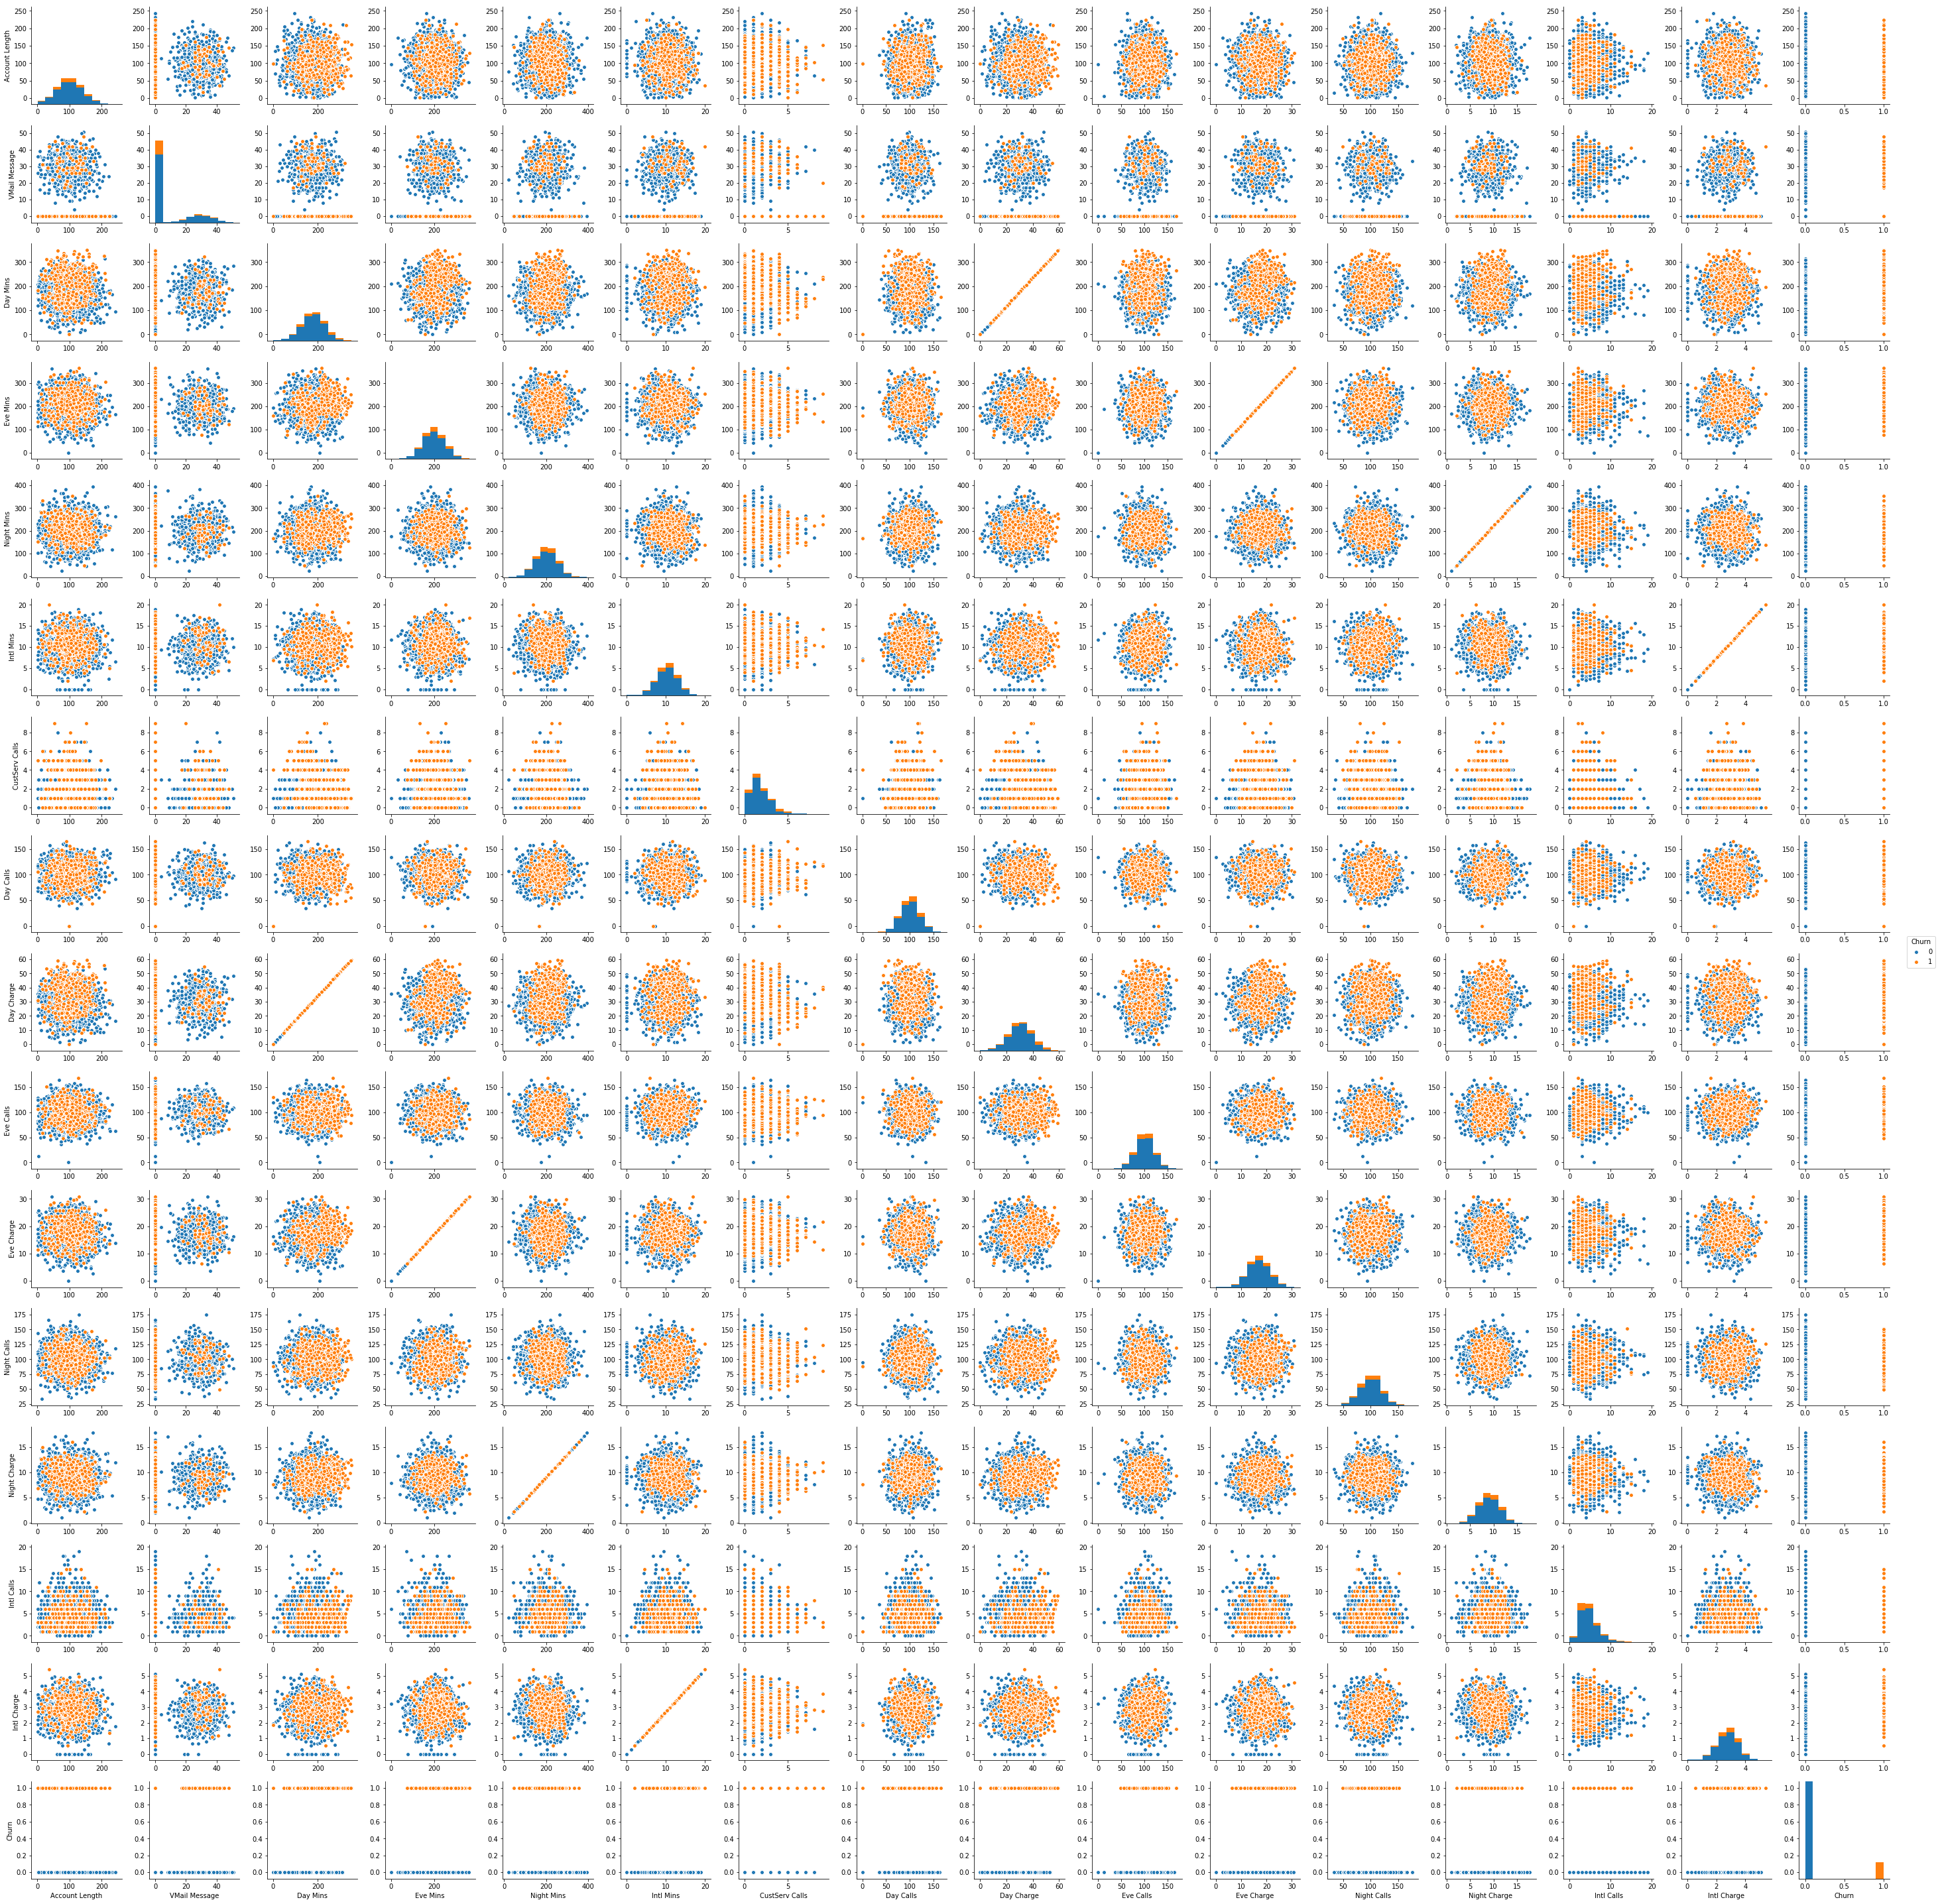

In [14]:
con_vars.append('Churn')
sns.pairplot(train[con_vars], hue='Churn')
con_vars.remove('Churn')

We can see that, largely, our two classes are not linearly separable. Linear classifiers, like perceptron and linear support vector machine, will have a hard time capturing these patterns. .

Moving on, we can start by using a t-test to compare means of our of two classes (with variables with approximately normal distributions) and chi-square tests to similarly look for significantly different representations among categorical variables.

In [15]:
def t_test(df, target, variables, alpha=0.05):
    non_describe = df[df[target] == 0][variables].describe()
    pro_describe = df[df[target] == 1][variables].describe()
    t_scores = []
    p_values = []
    for var in variables:
        t_temp = stats.ttest_1samp(df[df[target] == 1][var], df[df[target] == 0][var].mean())
        t_scores.append(t_temp[0].round(2))
        p_values.append(t_temp[1].round(4))
    t_score_df = pd.DataFrame(data={'0 Mean': non_describe.loc['mean'], '1 Mean': pro_describe.loc['mean'],'T Stat': t_scores, 'Difference': abs(non_describe.loc['mean'] - pro_describe.loc['mean']),'P-Value': p_values}, index=df[variables].columns)
    rel_t_score = t_score_df[t_score_df['P-Value'] <= alpha]
    irrel_t_score = t_score_df[t_score_df['P-Value'] >= alpha]
    return (t_score_df.sort_values('P-Value'), rel_t_score, irrel_t_score)

Looks like the length of a customer's stay with the company, or the number of calls they've made, are not significant. We can get a closer look by visualizing the distributions of these variables, but first we need to examine our categorical variables.

In [16]:
def chi_sq(df, target, variables, alpha=0.05):
    chi_sq = chi2(df[variables], df[target])
    chi_scores_df = pd.DataFrame(data={'P-Value': chi_sq[1].round(3), 'Chi-Sq.': chi_sq[0]}, index=variables)
    rel_chi_sq = chi_scores_df[chi_scores_df['P-Value'] <= alpha]
    irrel_chi_sq = chi_scores_df[chi_scores_df['P-Value'] >= alpha]
    return(chi_scores_df.sort_values('Chi-Sq.', ascending=False), rel_chi_sq, irrel_chi_sq)

vars_chi_sq = chi_sq(train, 'Churn', cat_vars)
vars_chi_sq[0]

Chi-Sq.  P-Value
Intl Plan   159.409799    0.000
VMail Plan   20.749326    0.000
State         2.251203    0.134
Area Code     1.096047    0.295

A customer's geography also doesn't seem to be relevant.

Visualizations will help us better understand our variables.

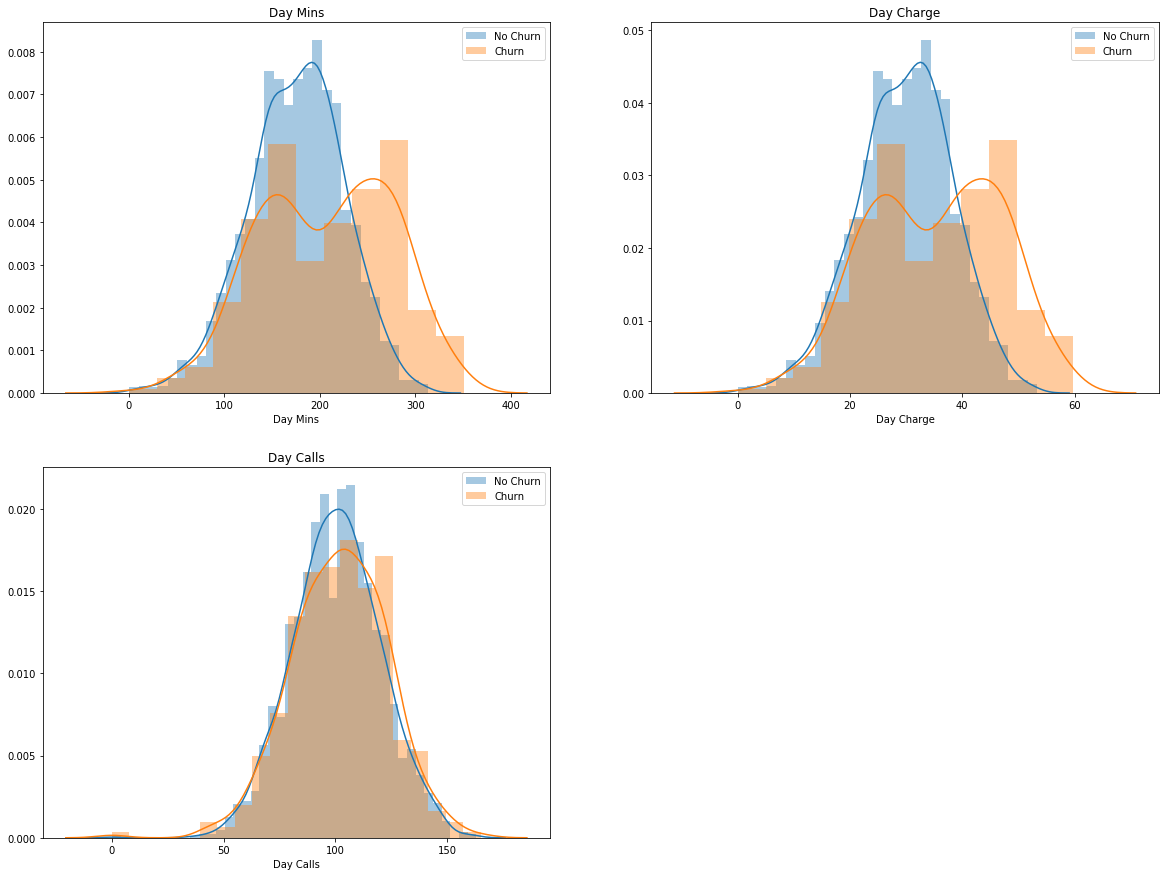

In [17]:
plt.figure(figsize=(20, 15))
for i, var in enumerate(['Day Mins', 'Day Charge', 'Day Calls']):
    plt.subplot(2, 2, i+1)
    sns.distplot(train[train['Churn'] == 0][var], label=['No Churn'])
    sns.distplot(train[train['Churn'] == 1][var], label=['Churn'])
    plt.xlabel=var
    plt.title(var)
    plt.legend()

When looking at "Day Mins" and "Day Charge", our two classes have substantially separate curves. The distribution for customers who defected is distinctly bimodal for "Day Mins" and "Day Charge". This peakedness tells me that while both classes might place approximately the same number of calls during the day, customers who turned over talked on the phone the most, and thus were charged the most. This gives me the impression that high fees are pushing the most talkative customers away.

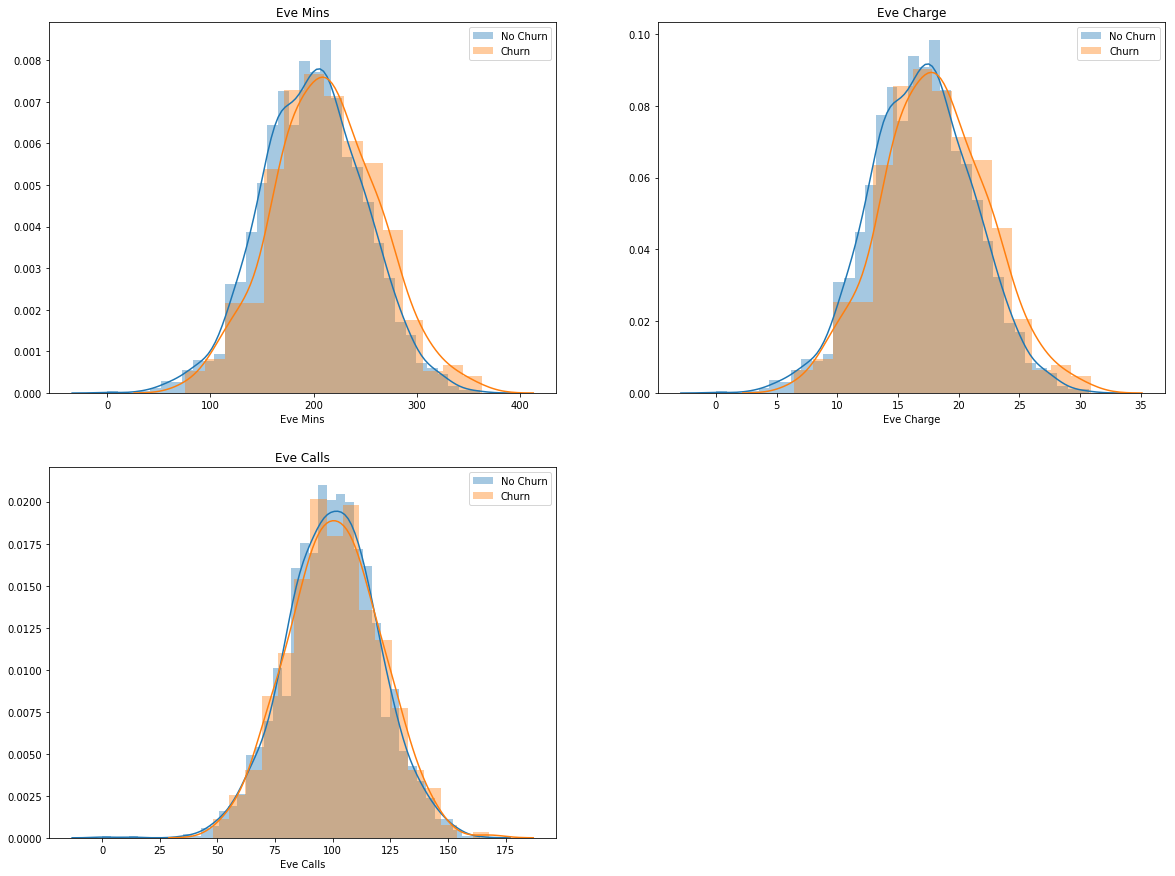

In [18]:
plt.figure(figsize=(20, 15))
for i, var in enumerate(['Eve Mins', 'Eve Charge', 'Eve Calls']):
    plt.subplot(2, 2, i+1)
    sns.distplot(train[train['Churn'] == 0][var], label=['No Churn'])
    sns.distplot(train[train['Churn'] == 1][var], label=['Churn'])
    plt.xlabel=var
    plt.title(var)
    plt.legend()

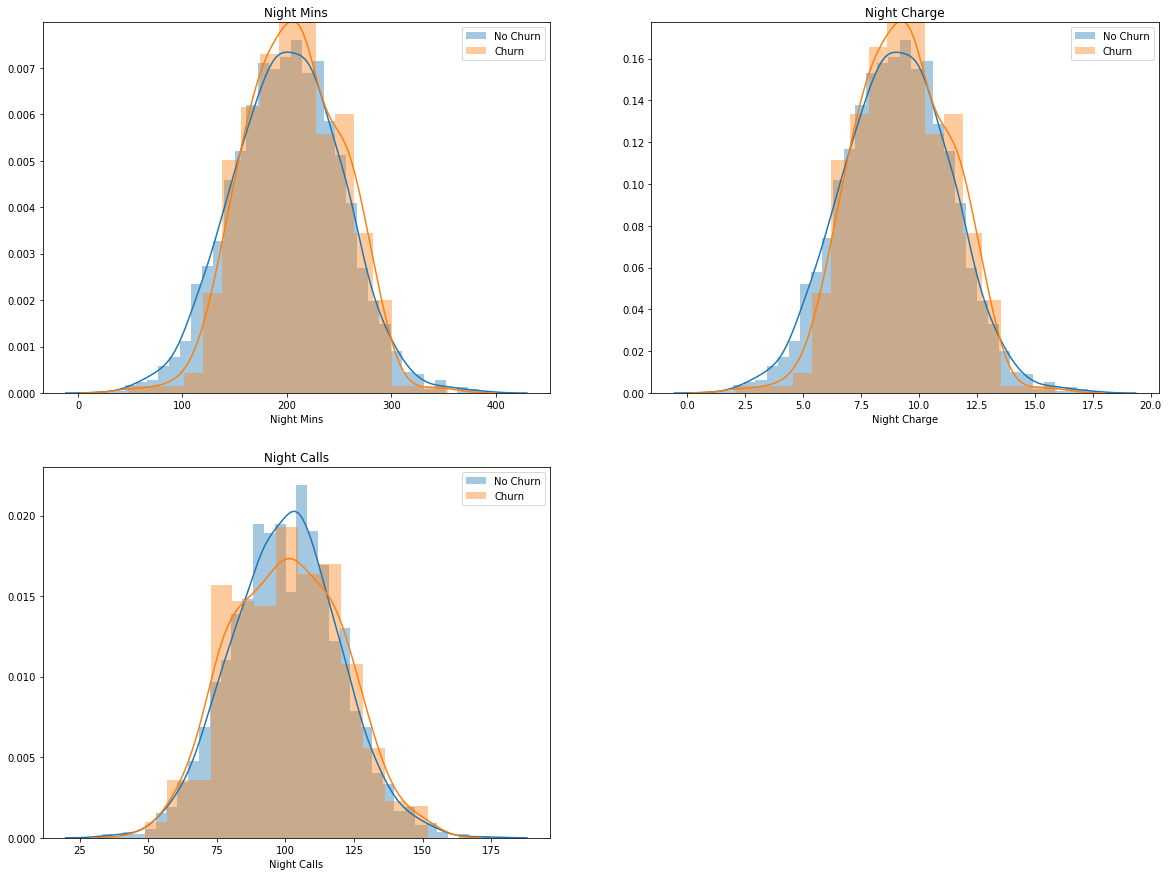

In [19]:
plt.figure(figsize=(20, 15))
for i, var in enumerate(['Night Mins', 'Night Charge', 'Night Calls']):
    plt.subplot(2, 2, i+1)
    sns.distplot(train[train['Churn'] == 0][var], label=['No Churn'])
    sns.distplot(train[train['Churn'] == 1][var], label=['Churn'])
    plt.xlabel=var
    plt.title(var)
    plt.legend()

It's the same story for evening and nighttime behavior, though the difference between classes is not nearly as pronounced as daytime behavior. This makes sense, since this is when we expect most calls to take place.

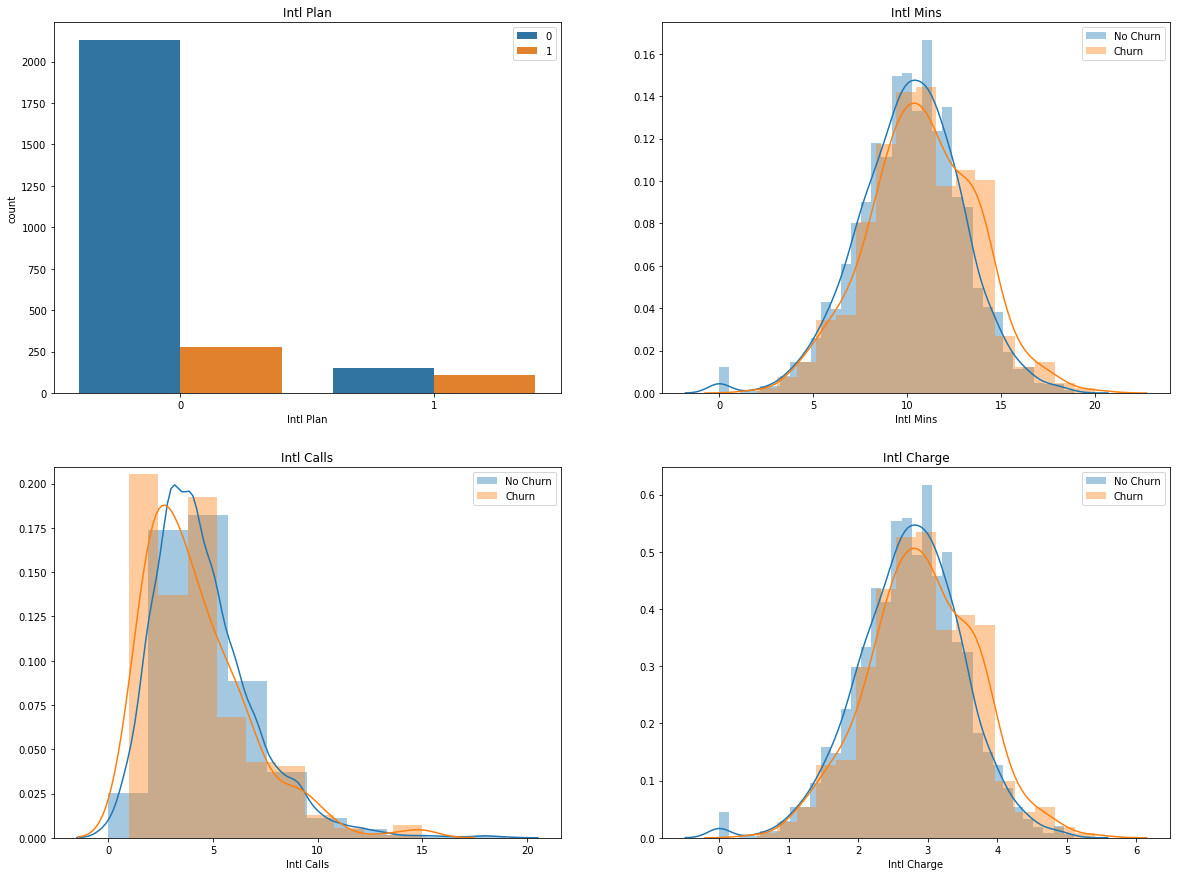

In [20]:
plt.figure(figsize=(20, 15))
for i, var in enumerate(['Intl Plan', 'Intl Mins', 'Intl Calls', 'Intl Charge']):
    plt.subplot(2, 2, i+1)
    if var == 'Intl Plan':
        sns.countplot(data=train, x=var, hue='Churn')
    elif var == 'Intl Calls':
        sns.distplot(train[train['Churn'] == 0][var], bins=10, label=['No Churn'])
        sns.distplot(train[train['Churn'] == 1][var], bins=10, label=['Churn'])
    else:
        sns.distplot(train[train['Churn'] == 0][var], label=['No Churn'])
        sns.distplot(train[train['Churn'] == 1][var], label=['Churn'])
    plt.xlabel=var
    plt.title(var)
    plt.legend()

Once again the difference is slight, but customers who did not renew their contract put in more minutes and were likewise charged more than customers who stayed. This time it seems customers who did not renew their contract actually made fewer calls than customers who did.

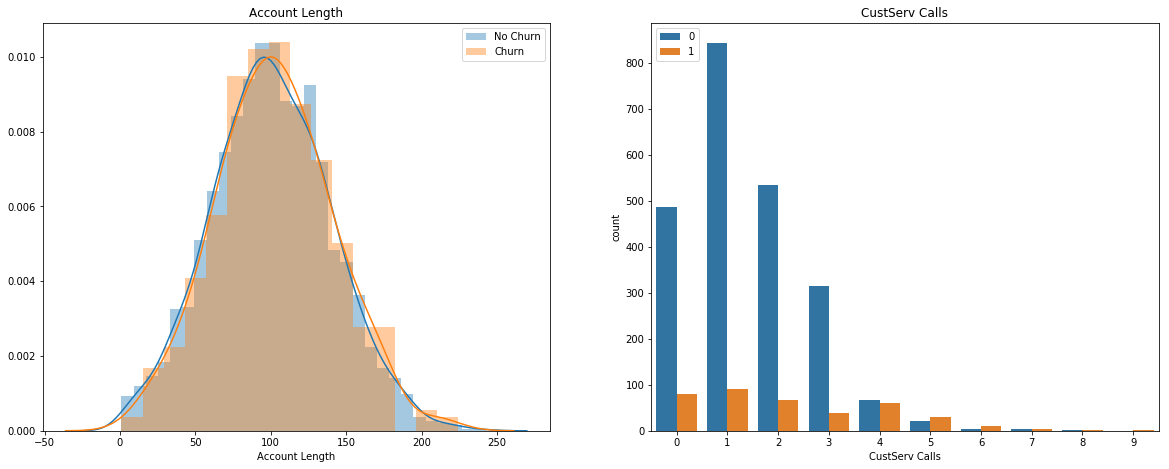

In [21]:
plt.figure(figsize=(20, 7.5))
for i, var in enumerate(['Account Length', 'CustServ Calls']):
    plt.subplot(1, 2, i+1)
    if var == 'CustServ Calls':
        sns.countplot(data=train, x=var, hue='Churn')
    else:
        sns.distplot(train[train['Churn'] == 0][var], label=['No Churn'])
        sns.distplot(train[train['Churn'] == 1][var], label=['Churn'])
    plt.xlabel=var
    plt.title(var)
    plt.legend()

It appears that a customer's time with the company has no impact on their decision to leave or stay. We can also see that many customers had a small handful of customer service calls over their lifetime, but customers who left the company are more evenly distributed across multiple customer service calls.

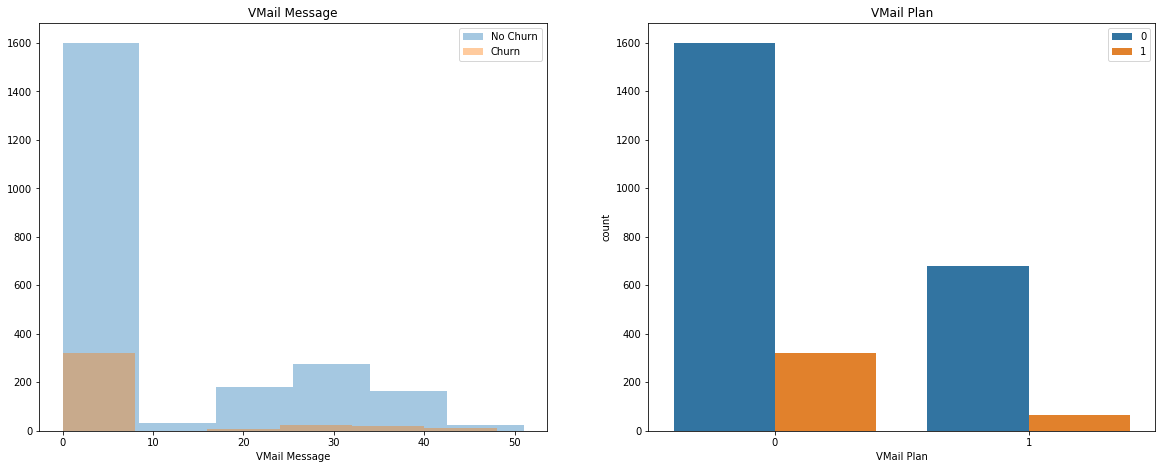

In [22]:
plt.figure(figsize=(20, 7.5))
for i, var in enumerate(['VMail Message', 'VMail Plan']):
    plt.subplot(1, 2, i+1)
    if var == 'VMail Plan':
        sns.countplot(data=train, x=var, hue='Churn')
    else:
        sns.distplot(train[train['Churn'] == 0][var], bins=6, label=['No Churn'], kde=False)
        sns.distplot(train[train['Churn'] == 1][var], bins=6, label=['Churn'], kde=False)
    plt.xlabel=var
    plt.title(var)
    plt.legend()

While both classes are unlikely to belong to the VMail plan, most of the customers who turned over did not have the Vmail plan; of those who did, very few left.

Some demographic information would have proved useful in this dataset, such as age, sex, and occupation. These would help us develop our understanding patterns in these customers' behavior and practices.

I spy a chance to do a little engineering. We have four different variables that describe customers' charges, calls, and call minutes at various times of day. All of the minutes and charge variables were valuable to us, with customers who turned over having a greater mean in both categories. I'll make variables for total charges and total minutes, which should give us couple more meaningful variables to aid in our analysis.

In [23]:
df['Total Mins'] = df['Day Mins'] + df['Eve Mins'] + df['Night Mins'] + df['Intl Mins']
df['Total Charge'] = df['Day Charge'] + df['Eve Charge'] + df['Night Charge'] + df['Intl Charge']
con_vars.extend(['Total Mins', 'Total Charge'])

In [24]:
df[['Total Mins', 'Total Charge']].describe()

Total Mins  Total Charge
count  3333.000000   3333.000000
mean    591.864776     59.449754
std      89.954251     10.502261
min     284.300000     22.930000
25%     531.500000     52.380000
50%     593.600000     59.470000
75%     652.400000     66.480000
max     885.000000     96.150000

In [25]:
X, X_holdout, y, y_holdout = train_test_split(df.drop('Churn', axis=1), df['Churn'], test_size=0.20, random_state=15)
train = pd.concat([X, y], axis=1)

In [26]:
X_scaled = CustomScaler(['State', 'Intl Plan', 'Area Code', 'VMail Plan']).fit_transform(X)
X_hold_scaled = CustomScaler(['State', 'Intl Plan', 'Area Code', 'VMail Plan']).fit_transform(X_holdout)

In [27]:
con_vars = df.drop(cat_vars, axis=1).drop('Churn', axis=1).columns.tolist()

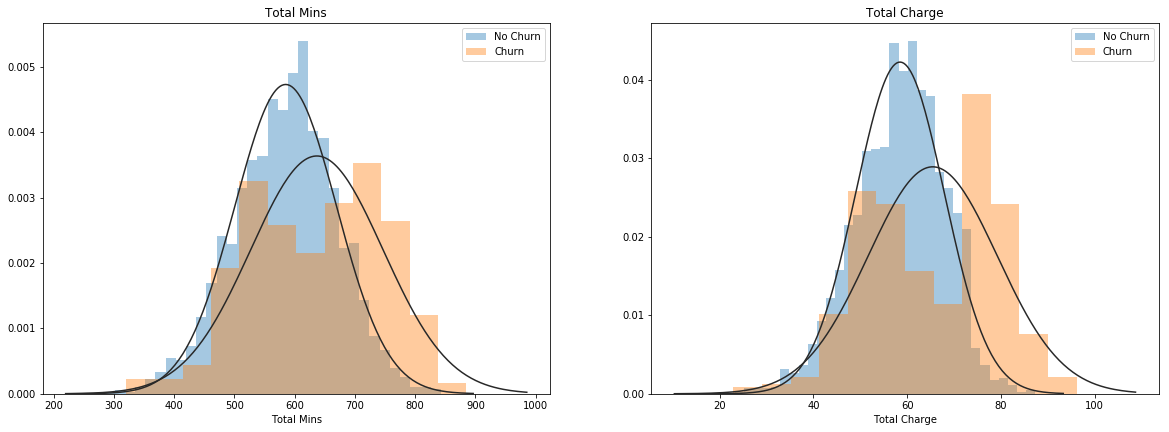

In [28]:
plt.figure(figsize=(20, 15))
for i, var in enumerate(['Total Mins', 'Total Charge']):
    plt.subplot(2, 2, i+1)
    sns.distplot(train[train['Churn'] == 0][var], label=['No Churn'], fit=stats.norm, kde=False)
    sns.distplot(train[train['Churn'] == 1][var], label=['Churn'], fit=stats.norm, kde=False)
    plt.xlabel=var
    plt.title(var)
    plt.legend()

In [29]:
con_vars.remove('Day Mins')
con_vars.remove('Day Charge')
vars_t_test = t_test(train, 'Churn', con_vars)
con_vars.append('Day Mins')
con_vars.append('Day Charge')
vars_t_test[0]

0 Mean      1 Mean  Difference  P-Value  T Stat
VMail Message     8.688596    5.313472    3.375125   0.0000   -5.41
Eve Mins        199.101140  212.089637   12.988497   0.0000    4.99
Intl Mins        10.156096   10.799741    0.643644   0.0000    4.43
CustServ Calls    1.448246    2.202073    0.753827   0.0000    7.90
Eve Charge       16.923820   18.027824    1.104004   0.0000    4.99
Intl Charge       2.742636    2.916477    0.173841   0.0000    4.43
Total Mins      584.962675  636.708290   51.745615   0.0000    9.25
Total Charge     58.494417   65.465155    6.970739   0.0000    9.92
Night Mins      200.340351  206.632383    6.292033   0.0070    2.71
Night Charge      9.015346    9.298601    0.283255   0.0070    2.71
Intl Calls        4.542982    4.207254    0.335729   0.0094   -2.61
Day Calls       100.542544  101.777202    1.234658   0.2572    1.13
Account Length  100.500877  102.569948    2.069071   0.2937    1.05
Eve Calls        99.870614  100.823834    0.953220   0.3434    0.95
Night Calls     100.117544  100.455959    0.338415   0.7402    0.33

As we'd expected, our new variables will come in handy.

In [30]:
optimal_feats = vars_chi_sq[1].index.tolist() + vars_t_test[1].index.tolist() + ['Day Mins', 'Day Charge']
optimal_feats

['Intl Plan',
 'VMail Plan',
 'VMail Message',
 'Eve Mins',
 'Night Mins',
 'Intl Mins',
 'CustServ Calls',
 'Eve Charge',
 'Night Charge',
 'Intl Calls',
 'Intl Charge',
 'Total Mins',
 'Total Charge',
 'Day Mins',
 'Day Charge']

The time has come to start working with models. We'll jump into tree ensembles, including random forest, AdaBoost and gradient boosting. These implementations can be used to conduct their own multivariate selection of features.

# Tree Ensembles

Random forest and gradient boosting are robust non-linear algorithms that we'll fine tune to start making predictions on our data set. Random foreset utilizes "bagging" to fit multiple estimators on random subsets of the dataset to reduce variance, while boosting methods combine weak estimators with high bias into an ensemble with lower intrinsic bias.

The below class will plot out different accuracy measures (accuracy, f1, recall, precision) for a model by recursively eliminating features in order of importance using cross-validation.

It's important to look at different accuracy measures other than simple "accuracy" based on the context of the problem. 
* *Accuracy* is a percentage of correctly chosen values. Accuracy can be misleading: if we built a model that predicted all the observations to be negative, and none to be positive (which is the whole point of the classifier), then we would still have correctly predicted all of the true negative values, giving us an accuracy of 85%.
* *Precision* is the percentage of observations that we're predicted to be one class or another and indeed belonged to that class.
* *Recall* is the percentage of all observations of a given class (in this case positive or negative) that we're correctly chosen by the classifier. In terms of customer turnover detection, we need to pay particular attention to recall. It would almost certainly cost less to push retention promotions to at-risk customers than it would be to find new customers to replace them; therefore, our priority is to ensure that as few as possible at-risk customers slip under the radar.
* *F1 or F Measure* is the weighted harmonic mean between precision and recall, combining the two metrics into a single value. When looking at a model big picture, this is a more meaningful value than accuracy.

Our class below will plot out the performance of our models based on the variables used in the predictions in order of importance.

In [31]:
class CVRFEPlot:
    def __init__(self, model_dict, fig_width=20, fig_height=7.5, ylim=(0, 1), cv=10, n_jobs=-1):
        self.model_dict = model_dict
        self.fig_width = fig_width
        self.fig_height = fig_height
        self.cv = cv
        self.measure_dict = {}  
        self.n_jobs = n_jobs
        self.ylim = ylim
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        for alias, model in self.model_dict.items():
            self.measure_dict[alias] = {
                'acc': RFECV(estimator=model, cv=self.cv, scoring='accuracy', n_jobs=self.n_jobs).fit(self.X, self.y),
                'rec': RFECV(estimator=model, cv=self.cv, scoring='recall', n_jobs=self.n_jobs).fit(self.X, self.y),
                'pre': RFECV(estimator=model, cv=self.cv, scoring='precision', n_jobs=self.n_jobs).fit(self.X, self.y),
                'f1': RFECV(estimator=model, cv=self.cv, scoring='f1', n_jobs=self.n_jobs).fit(self.X, self.y)
            }
            setattr(self, '{0}_acc_'.format(alias), self.measure_dict[alias]['acc'])
            setattr(self, '{0}_rec_'.format(alias), self.measure_dict[alias]['rec'])
            setattr(self, '{0}_pre_'.format(alias), self.measure_dict[alias]['pre'])
            setattr(self, '{0}_f1_'.format(alias), self.measure_dict[alias]['f1'])
        return self
    
    def plot(self):
        model_len = len(self.model_dict)
        row_count = math.ceil(model_len/2)
        self.fig_height = 7.5*row_count
        plt.figure(figsize=(self.fig_width, self.fig_height))
        for i, model in enumerate(self.measure_dict.keys()):
            title = str(self.model_dict[model]).split('(')[0]
            plt.subplot(row_count, 2, i+1)
            plt.title(title)
            plt.plot(range(1, len(self.measure_dict[model]['acc'].grid_scores_) + 1), self.measure_dict[model]['acc'].grid_scores_, c='b', label='Accuracy')
            plt.plot(range(1, len(self.measure_dict[model]['pre'].grid_scores_) + 1), self.measure_dict[model]['pre'].grid_scores_, c='g', label='Precision')
            plt.plot(range(1, len(self.measure_dict[model]['rec'].grid_scores_) + 1), self.measure_dict[model]['rec'].grid_scores_, c='r', label='Recall')
            plt.plot(range(1, len(self.measure_dict[model]['f1'].grid_scores_) + 1), self.measure_dict[model]['f1'].grid_scores_, c='c', label='f1')
            plt.legend(title='Accuracy Measure')
            plt.xticks(range(1, len(self.measure_dict[model]['acc'].grid_scores_) + 1))
            plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
            plt.ylim(self.ylim)
            plt.grid()
        plt.show()

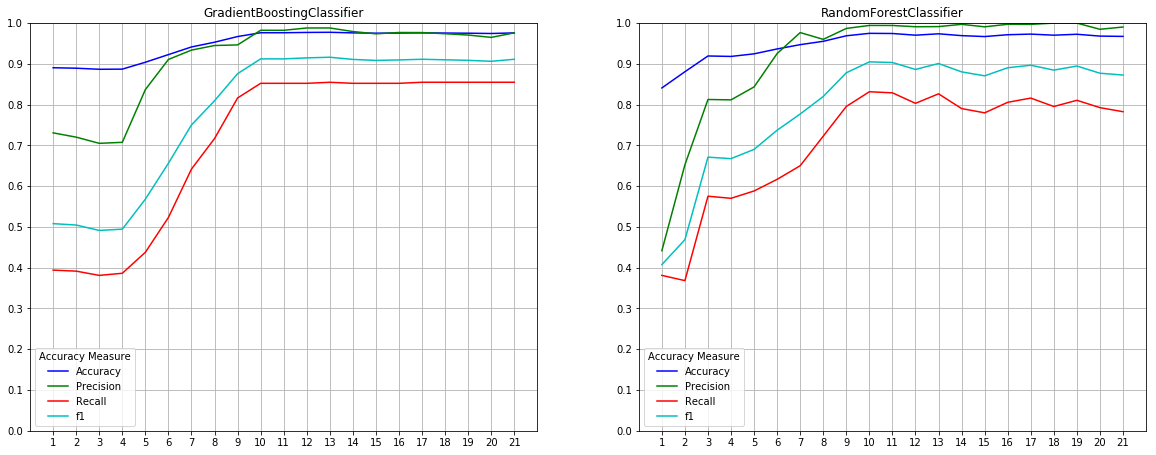

In [32]:
trees_rfe = CVRFEPlot({'gb': GradientBoostingClassifier(random_state=10), 'rf': RandomForestClassifier(random_state=10)}).fit(X, y)
trees_rfe.plot()

Both models look extremely promising, in fact better than I expected. We can shrink our dataset down to the size of the most optimal combination of variables determined by our above class. These datasets of different sizes can be useful down the road to experiment with other models that don't support recursive feature elimination.

In [33]:
rf_X = pd.DataFrame(trees_rfe.rf_f1_.transform(X), columns=X.columns[trees_rfe.rf_f1_.support_ == True], index=X.index)
gb_X = pd.DataFrame(trees_rfe.gb_f1_.transform(X), columns=X.columns[trees_rfe.gb_f1_.support_ == True], index=X.index)
rf_X_scaled = pd.DataFrame(trees_rfe.rf_f1_.transform(X_scaled), columns=X.columns[trees_rfe.rf_f1_.support_ == True], index=X.index)
gb_X_scaled = pd.DataFrame(trees_rfe.gb_f1_.transform(X_scaled), columns=X.columns[trees_rfe.gb_f1_.support_ == True], index=X.index)

In [34]:
print('# rf_X features: {0}\n'.format(rf_X.columns.shape[0]))
print('rf_X features:\n {0}\n'.format(rf_X.columns.tolist()))
print('# gb_X features: {0}\n'.format(gb_X.columns.shape[0]))
print('gb_X features:\n {0}\n'.format(gb_X.columns.tolist()))
print('# Univariately-chosen features: {0}\n'.format(len(optimal_feats)))
print('Univariately-chosen features:\n {0}'.format(optimal_feats))

# rf_X features: 10

rf_X features:
 ['Day Mins', 'Eve Mins', 'Intl Mins', 'CustServ Calls', 'Intl Plan', 'VMail Plan', 'Day Charge', 'Intl Calls', 'Total Mins', 'Total Charge']

# gb_X features: 13

gb_X features:
 ['VMail Message', 'Night Mins', 'Intl Mins', 'CustServ Calls', 'Intl Plan', 'Day Charge', 'Eve Calls', 'Eve Charge', 'Night Charge', 'Intl Calls', 'Intl Charge', 'State', 'Total Charge']

# Univariately-chosen features: 15

Univariately-chosen features:
 ['Intl Plan', 'VMail Plan', 'VMail Message', 'Eve Mins', 'Night Mins', 'Intl Mins', 'CustServ Calls', 'Eve Charge', 'Night Charge', 'Intl Calls', 'Intl Charge', 'Total Mins', 'Total Charge', 'Day Mins', 'Day Charge']


Looks like our multivariate analysis was less forgiving than our univariate feature selection. Our engineered variables made the cut, and we can also see that the "State" variable, which was ruled out by univariate analysis, was tapped by gradient boosting, highlighting the importance of multivariate analysis.

# Gradient Boosting

We'll tune the parameters of our gradient boost model using grid search cross-validation. These grid searches will be exhaustively slow but they will be definitive.

In [35]:
def classif_report(true_results, predicted_results):
    print('Classifcation Report:\n')
    print(classification_report(true_results, predicted_results))
    print('\nConfusion Matrix:\n')
    print(pd.DataFrame(data=confusion_matrix(true_results, predicted_results), columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

In [36]:
grid_gb_params = {
    'max_depth': range(3, 9, 2),
    'max_features': range(1, gb_X.shape[1], 2),
    'n_estimators': [100, 200, 300, 400, 500, 750, 1000],
}
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=10), param_grid=grid_gb_params, n_jobs=-1, scoring='f1').fit(gb_X, y)
print(grid_gb.best_params_)
classif_report(cross_val_predict(grid_gb, gb_X, y, cv=5), y)

{'max_depth': 3, 'max_features': 3, 'n_estimators': 1000}
Classifcation Report:

             precision    recall  f1-score   support

          0       1.00      0.98      0.99      2335
          1       0.86      1.00      0.92       331

avg / total       0.98      0.98      0.98      2666


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0         2280           55
Actual 1            0          331


In [37]:
classif_report(grid_gb.predict(X_holdout[gb_X.columns]), y_holdout)

Classifcation Report:

             precision    recall  f1-score   support

          0       1.00      0.98      0.99       583
          1       0.87      1.00      0.93        84

avg / total       0.98      0.98      0.98       667


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0          570           13
Actual 1            0           84


Applied to our testing data, gradient boosting is exceptionally powerful. 100% recall of the positive class in a binary case such as this is a beautiful sight.

# Random Forest

In [38]:
grid_rf_params = {
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_depth': range(3, 9, 2),
    'max_features': range(1, rf_X.shape[1], 2),
    'n_estimators': [100, 200, 300, 400, 500, 750, 1000],
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=grid_rf_params, n_jobs=-1, scoring='f1').fit(rf_X, y)
print(grid_rf.best_params_)
classif_report(cross_val_predict(grid_rf, rf_X, y, cv=5), y)

{'class_weight': 'balanced', 'max_depth': 5, 'max_features': 7, 'n_estimators': 200}
Classifcation Report:

             precision    recall  f1-score   support

          0       1.00      0.97      0.99      2337
          1       0.85      0.99      0.91       329

avg / total       0.98      0.98      0.98      2666


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0         2278           59
Actual 1            2          327


In [39]:
classif_report(grid_rf.predict(X_holdout[rf_X.columns]), y_holdout)

Classifcation Report:

             precision    recall  f1-score   support

          0       1.00      0.98      0.99       583
          1       0.87      1.00      0.93        84

avg / total       0.98      0.98      0.98       667


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0          570           13
Actual 1            0           84


We've acheived a similarly outstanding showing with our random forest model, virtually identical. In practicality I'd be happy to leave it there, but for the purposes of this project, we'll give support vector machine a shot.

# Support Vector Machine

The default kernel for scikit-learn implementation of SVM is the radial-basis function, or RBF, which is a nonlinear kernel best suited for helping us generalize from this dataset. We'll conduct cross-validated grid searches like before with different subsets of the dataset, features selected via gradient boosting, random forest, and univariate analysis.

In [40]:
# In ascending order of size, random forest-selected features
grid_svm_rf_params = {
    'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'class_weight': ['balanced', None]
}

grid_svm_rf = GridSearchCV(SVC(random_state=10, class_weight='balanced'), param_grid=grid_svm_rf_params, n_jobs=-1, scoring='f1').fit(rf_X_scaled, y)
print(grid_svm_rf.best_params_)
classif_report(cross_val_predict(grid_svm_rf, rf_X_scaled, y, cv=5), y)

{'C': 100, 'class_weight': None, 'gamma': 0.1}
Classifcation Report:

             precision    recall  f1-score   support

          0       0.99      0.95      0.97      2365
          1       0.69      0.89      0.78       301

avg / total       0.95      0.94      0.95      2666


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0         2246          119
Actual 1           34          267


In [41]:
classif_report(grid_svm_rf.predict(X_hold_scaled[rf_X_scaled.columns]), y_holdout)

Classifcation Report:

             precision    recall  f1-score   support

          0       0.98      0.96      0.97       584
          1       0.75      0.88      0.81        83

avg / total       0.95      0.95      0.95       667


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0          560           24
Actual 1           10           73


In [42]:
# With gradient boosting-selected features
grid_svm_gb_params = {
    'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'class_weight': ['balanced', None]
}

grid_svm_gb = GridSearchCV(SVC(random_state=10, class_weight='balanced'), param_grid=grid_svm_gb_params, n_jobs=-1, scoring='f1').fit(gb_X_scaled, y)
print(grid_svm_gb.best_params_)
classif_report(cross_val_predict(grid_svm_gb, gb_X_scaled, y, cv=5), y)

{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.001}
Classifcation Report:

             precision    recall  f1-score   support

          0       0.90      0.94      0.92      2193
          1       0.66      0.54      0.60       473

avg / total       0.86      0.87      0.86      2666


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0         2063          130
Actual 1          217          256


In [43]:
classif_report(grid_svm_gb.predict(X_hold_scaled[gb_X.columns]), y_holdout)

Classifcation Report:

             precision    recall  f1-score   support

          0       0.89      0.97      0.92       522
          1       0.82      0.55      0.66       145

avg / total       0.87      0.88      0.87       667


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0          505           17
Actual 1           65           80


In [44]:
# And with features picked via univariate analysis
grid_svm_of_params = {
    'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'class_weight': ['balanced', None]
}

grid_svm_of = GridSearchCV(SVC(random_state=10, class_weight='balanced'), param_grid=grid_svm_of_params, n_jobs=-1, scoring='f1').fit(X_scaled[optimal_feats], y)
print(grid_svm_of.best_params_)
classif_report(cross_val_predict(grid_svm_of, X_scaled[optimal_feats], y, cv=5), y)

{'C': 1000, 'class_weight': None, 'gamma': 0.01}
Classifcation Report:

             precision    recall  f1-score   support

          0       0.98      0.95      0.96      2373
          1       0.67      0.88      0.76       293

avg / total       0.95      0.94      0.94      2666


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0         2244          129
Actual 1           36          257


In [45]:
classif_report(grid_svm_of.predict(X_hold_scaled[optimal_feats]), y_holdout)

Classifcation Report:

             precision    recall  f1-score   support

          0       0.98      0.96      0.97       579
          1       0.76      0.84      0.80        88

avg / total       0.95      0.94      0.95       667


Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0          556           23
Actual 1           14           74


It appears that SVM trained on the random forest feature set also yields a satisfactory performance, but it doesn't quite top our tree methods for strength of accuracy.

# Final thoughts
* This project represents 3 months of numerous research efforts, studies, experiments, and small projects. The entire endeavor gave me extensive experience working with key concepts including:
    * boosting and bagging
    * over- and under-sampling
    * linear separability
    * cross-validation
    * regularization and standardization/normalization
    * feature selection, engineering, and preprocessing
* I experimented with a number of methods and tricks that are not shown in this project for the sake of length, including:
    * Logistic regression
    * K-Nearest Neighbors
    * AdaBoost
    * Principle component analysis
    * SVM with bootstrapping
    * Under/over-sampling techniques, including SMOTE (this lead to egregious overfitting)
* There are still a lot of other topics in classification that I want to explore, because by no means am I an expert, but it's time to turn my attention to other worthy areas of study. I'll be aggressively turning my attention to new subjects before graduation time in May.